# Generate Dataset

In [16]:
import os, random
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import soundfile as sf
from audio_utilities import FeatureExtraction

In [2]:
def get_filepaths(dataset_dir, filter_format="wav", get_duration=False):

    filepath_array = []
    speech_duration = 0

    for i, (path, dir_name, file_name) in enumerate(os.walk(dataset_dir)):
        for file in file_name:
            if filter_format in file:
                filepath = path + "/" + file
                filepath_array.append(filepath)

                if get_duration:
                    load_file = sf.SoundFile(filepath)
                    speech_duration += len(load_file) / load_file.samplerate

    print("Got {} .{} Files".format(len(filepath_array), filter_format))
    if get_duration:
        print("Total Duration: {}m".format(int(speech_duration/60)))

    return filepath_array

def add_noise_speech(speech, noise, snr=5):

    rms_speech = sqrt(np.mean(speech ** 2))
    rms_noise_req = sqrt(rms_speech ** 2/pow(10, snr/10))

    rms_noise = sqrt(np.mean(noise ** 2))
    noise_mod = noise * (rms_noise/rms_noise_req)

    return speech + noise_mod

def get_melbands_gain(clean_speech_stft, noisy_speech_stft, melbands=22):

    clean_mel = audio_utils.get_melspectrogram(audio_stft=clean_speech_stft, number_of_melbands=melbands)
    noisy_mel = audio_utils.get_melspectrogram(audio_stft=noisy_speech_stft, number_of_melbands=melbands)

    gains_speech = np.sqrt(np.divide(clean_mel, noisy_mel))
    # gains_speech = np.where(gains_speech <= 0.01, 0.01, gains_speech)
    # gains_speech = np.divide(gains_speech, np.max(gains_speech))

    return gains_speech

def get_features(clean_speech, noisy_speech, melbands=22):

    # Extract MFCC & Relative Derivatives
    noisy_speech_stft = audio_utils.stft(noisy_speech)
    noisy_speech_mfcc = audio_utils.get_mfccs_from_spectrogram(noisy_speech_stft,
                                                               number_of_melbands=22)
    noisy_speech_mfcc_delta, \
    noisy_speech_mfcc_delta2 = audio_utils.get_mfccs_delta(noisy_speech_mfcc,
                                                           number_of_melbands=9)

    # Extract Spectral Centroid & Bandwidth
    noisy_speech_spec_centroid = audio_utils.get_spectral_centroid(audio_stft=noisy_speech_stft)
    noise_speech_spec_bandwidth = audio_utils.get_spectral_bandwidth(audio_stft=noisy_speech_stft)

    # Extract Gains
    speech_concat_stft = audio_utils.stft(clean_speech)
    speech_melband_gains = get_melbands_gain(clean_speech_stft=speech_concat_stft,
                                             noisy_speech_stft=noisy_speech_stft,
                                             melbands=melbands)

    return  noisy_speech_mfcc, noisy_speech_mfcc_delta, noisy_speech_mfcc_delta2, \
            noisy_speech_spec_centroid, noise_speech_spec_bandwidth, speech_melband_gains


In [18]:

sampling_rate = 16000
frame_length = 1024
hop_length = 512
window_length = 1024
window_function = "vorbis"
number_of_melbands = 22
number_of_features = 42

snr_req = [-5, 0, 5]
# features_speech = []
# features_gain = []
features_speech = np.ndarray((number_of_features,0))
features_gain = np.ndarray((number_of_melbands, 0))

audio_utils = FeatureExtraction(sampling_rate=sampling_rate,
                                frame_length=frame_length, hop_length=hop_length,
                                window_length=window_length, window_function=window_function)

noise_database_path = "Dataset Structure/Dataset/Noise"
speech_database_path = "Dataset Structure/Dataset/Speech"
print("Noise: {}\nSpeech: {}\n".format(noise_database_path, speech_database_path))

noise_file_paths = get_filepaths(dataset_dir=noise_database_path, get_duration=True)
speech_file_paths = get_filepaths(dataset_dir=speech_database_path, get_duration=True)


Noise: Dataset Structure/Dataset/Noise
Speech: Dataset Structure/Dataset/Speech

Got 4 .wav Files
Total Duration: 4m
Got 136 .wav Files
Total Duration: 6m


In [19]:
# for snr in snr_req:
#     print("\n========== SNR {} ============".format(snr))

for noise_file_path in noise_file_paths:

    # Load Noise
    noise_file = audio_utils.load_audiofile(noise_file_path)
    print("\nCurrently Used Noise:", noise_file_path, len(noise_file))

    speech_file_iterator = 0
    while speech_file_iterator < len(speech_file_paths):

        speech_file = audio_utils.load_audiofile(speech_file_paths[speech_file_iterator])
        speech_concat = speech_file

        # Concat Speech Till Size of Noise
        while len(speech_concat) < len(noise_file):

            speech_file_iterator += 1

            # Break when file ends
            if speech_file_iterator >= len(speech_file_paths):
                # print(speech_file_iterator)
                break
            else:
                speech_file = audio_utils.load_audiofile(speech_file_paths[speech_file_iterator])
                speech_concat = np.concatenate((speech_concat, speech_file))
                print("Audio To Be Added: ", speech_file_paths[speech_file_iterator])

                if len(speech_concat) >= len(noise_file):

                    # Truncate Speech Array to Noise Length
                    speech_concat = speech_concat[:len(noise_file)]

                    # Add Noise to Speech
                    random_snr = random.randint(0, len(snr_req)-1)
                    noisy_speech = add_noise_speech(speech_concat, noise_file, snr=snr_req[random_snr])

                    # Get Features
                    mfcc, mfcc_d, mfcc_d2, \
                    spec_centroid, spec_bandwidth, gains = get_features(clean_speech=speech_concat,
                                                                        noisy_speech=noisy_speech)

                    # print(len(mfcc), len(mfcc_d), len(mfcc_d2),
                    #       len(spec_centroid), len(spec_bandwidth), len(gains))

                    # Add Features to Array
                    features = np.concatenate((mfcc, mfcc_d, mfcc_d2,
                                               spec_bandwidth, spec_centroid), axis=0)

                    features_speech = np.concatenate((features_speech, features), axis=1)
                    features_gain = np.concatenate((features_gain, gains), axis=1)

                    print("Added Noise to Speech: ", features_speech.shape, features_gain.shape, "\n")

                    break


Currently Used Noise: Dataset Structure/Dataset/Noise/Selected/Combined/babble.wav 966029
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA01_09.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA02_05.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA02_07.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA02_02.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA05_10.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA04_04.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA04_02.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA02_03.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA04_05.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA04_03.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA06_04.wav
Audio To Be Added:  Dataset Structure/Dataset/Speech/TSP/48k/CA/CA03_10.w

### Save to File

In [ ]:
print("Saving To File")
np.savez_compressed("feature_dataset.npz", speech_features=features_speech, gains=features_gain)

### Loading From File

In [80]:
from sklearn.model_selection import train_test_split
print("Loading From File")

filename = "feature_dataset.npz"

with np.load(filename) as data:
    speech_features = data["speech_features"]
    gains = data["gains"]
    # print(np.max(gains))

    # for i in range(0, 2):
    #     speech_features = np.concatenate((speech_features, speech_features), axis=1)
    #     gains = np.concatenate((gains, gains), axis=1)
    #     print("Concat Iteration {}".format(i))

    # gains = np.clip(gains, 0, 1)
    # print(np.max(gains))

    # Reshape (if Reqd)
    speech_features = speech_features.transpose()
    gains = gains.transpose()

    print(speech_features.shape, gains.shape)

    # x_train, x_test, y_train, y_test = train_test_split(speech_features, gains,
    #                                                     test_size=0.3)

    # x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train,
    #                                                                 test_size=0.2)

    window_size = 2000
    number_of_sequences = int(len(speech_features)/window_size)

    x = speech_features[:number_of_sequences*window_size]
    y = gains[:number_of_sequences*window_size]

    print(x.shape, y.shape)

    x_train = np.reshape(x, (number_of_sequences, window_size, x.shape[1]))
    y_train = np.reshape(y, (number_of_sequences, window_size, y.shape[1]))

    print(x_train.shape, y_train.shape)

Loading From File
(152154, 42) (152154, 22)
(152000, 42) (152000, 22)
(76, 2000, 42) (76, 2000, 22)


# Equalizer

In [69]:
# Create Noisy Speech

speech_file = "Audio Samples/Female_Speech.WAV"
noise_file = "Audio Samples/Kindergarten_Noise.wav"

speech = audio_utils.load_audiofile(speech_file)
noise = audio_utils.load_audiofile(noise_file)[:len(speech)]

noisy_speech = add_noise_speech(speech, noise, snr=5)
ipd.Audio(noisy_speech, rate=16000)

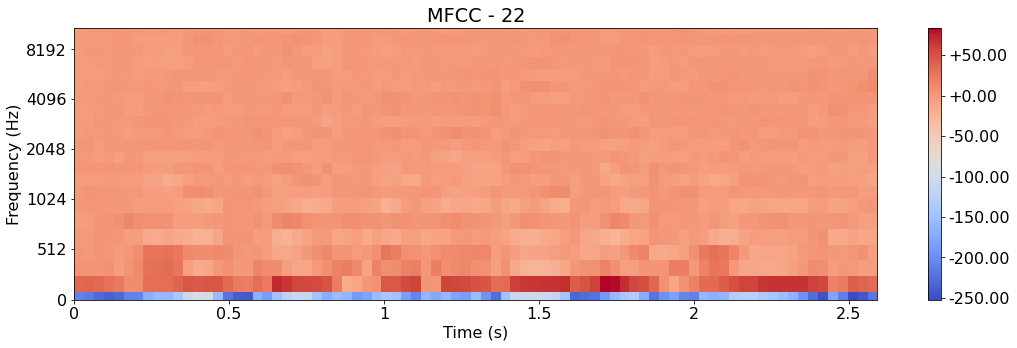

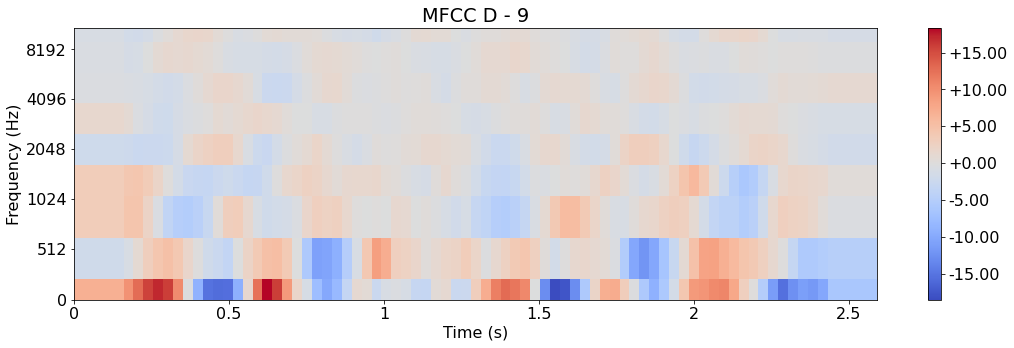

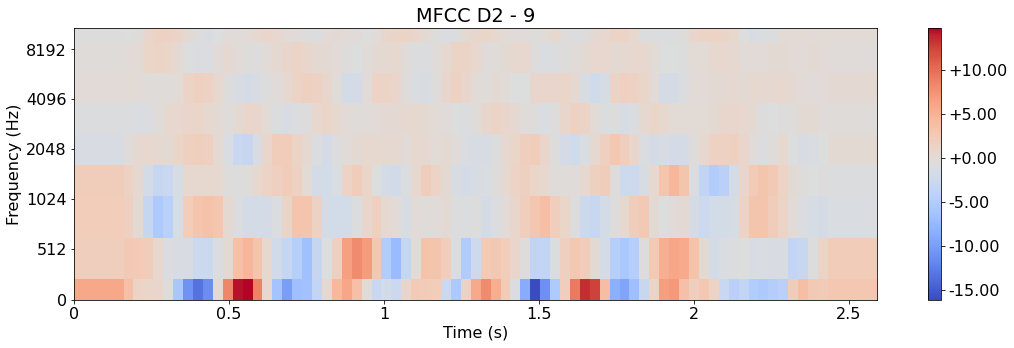

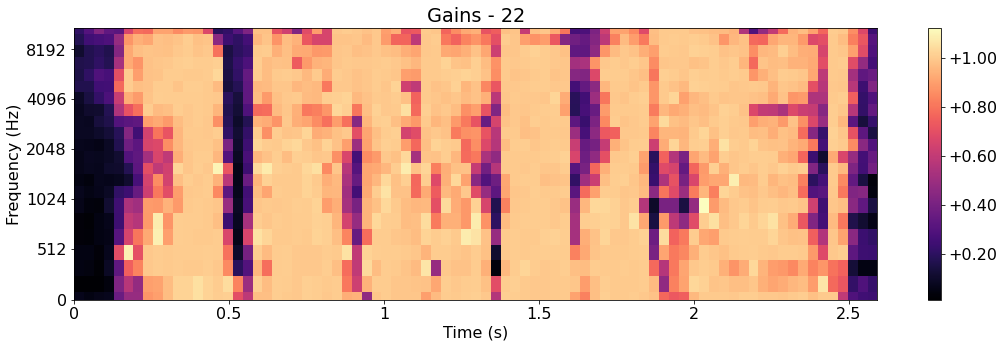

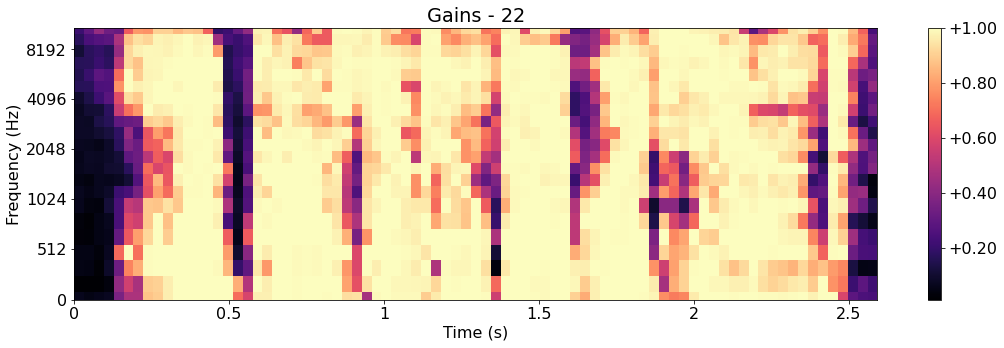

In [71]:
# Generate Features
mfcc, mfcc_d, mfcc_d2, \
spec_centroid, spec_bandwidth, gains = get_features(clean_speech=speech,
                                                    noisy_speech=noisy_speech)

def plot_feature(feature, sr=16000, title=""):
    plt.figure(figsize=(18, 5))
    librosa.display.specshow(data=feature, sr=sr,
                             x_axis="time", y_axis="mel")
    plt.colorbar(format="%+.2f")
    plt.title((title+" - {}").format(len(feature)))
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

plot_feature(mfcc, title="MFCC")
plot_feature(mfcc_d, title="MFCC D")
plot_feature(mfcc_d2, title="MFCC D2")
plot_feature(gains, title="Gains")

# Clipped Gains
# print(np.max(gains))
gains = np.clip(gains, 0, 1)

plot_feature(gains, title="Gains")

2
